# Decoding instantaneous table velocity from V1 population activity

In [3]:
%reset
# Core
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Reuse your decoding classes from the module you provided
import functions_for_decoding as fun

# Extras used in this notebook
from scipy import stats
import h5py
import random

# Reproducibility
np.random.seed(0)
random.seed(0)

plt.rcParams['figure.dpi'] = 120
plt.rcParams['figure.facecolor'] = 'white'


Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


## Load data

In [5]:
def load_vestibular_v1_sources(filename="vestibular_V1_sources.h5"):
    out = {}
    with h5py.File(filename, "r") as f:
        out["responses"] = {k: f["responses"][k][()] for k in f["responses"].keys()}
        out["velocity"]  = {k: f["velocity"][k][()]  for k in f["velocity"].keys()}
        out["trial_direction"] = f["metadata/trial_direction"][()]
        out["time"]            = f["metadata/time"][()]
        # info table (column-by-column)
        info = {}
        for col in f["metadata/info"].keys():
            vals = f["metadata/info"][col][()]
            if len(vals)>0 and isinstance(vals[0], (bytes, np.bytes_)):
                vals = [v.decode() for v in vals]
            info[col] = vals
        out["info"] = pd.DataFrame(info)
    return out

# Put the .h5 next to this notebook
DATAFILE = "vestibular_V1_sources.h5"
ds = load_vestibular_v1_sources(DATAFILE)

# Choose condition
cond = "control"  # ("MSC", "LED", "MSC_LED" also available if present)
resp = ds["responses"][cond]   # shape: (neurons, time_in_trial, trials)
vel  = ds["velocity"][cond]    # shape: (time_in_trial, trials)
info = ds["info"]              # neuron metadata

print("resp:", resp.shape, "vel:", vel.shape)
print("info cols:", list(info.columns))
print("Experiments:", np.unique(info["Experiment"]))


resp: (2887, 100, 54) vel: (100, 54)
info cols: ['Experiment', 'depth', 'n_cells']
Experiments: ['LP' 'V1' 'V1_LED' 'V1_LED_MSC' 'V1_MSC']


## Build matrices for the decoder

In [6]:
# The decoder expects:
#   Bspikes: (neurons, total_time)
#   Bvelocity: (total_time,)
# Trials are 100 bins (10 s @ 100 ms)
n, Ttrial, Ntr = resp.shape
assert Ttrial == 100, f"Expected trial length = 100 bins, got {Ttrial}"

# Flatten trials along time
Bspikes_all = resp.transpose(0, 2, 1).reshape(n, Ttrial * Ntr)   # (n, 100*Ntr)
Bvelocity   = vel.T.reshape(Ttrial * Ntr)                         # (100*Ntr,)

# Keep only V1-side recordings (exclude LP). 
info["depth"] = pd.to_numeric(info["depth"], errors="coerce")
mask_v1 = (info["Experiment"] != "LP") & (np.isfinite(info["depth"])) & (info["depth"] <= 1000)
info_v1 = info.loc[mask_v1].reset_index(drop=True)

Bspikes_v1 = Bspikes_all[mask_v1.values, :]

# Replace NaNs (if any) to keep sklearn happy
np.nan_to_num(Bspikes_v1, copy=False)
np.nan_to_num(Bvelocity,   copy=False)

print("V1 neurons:", Bspikes_v1.shape[0], "Total time bins:", Bspikes_v1.shape[1])


V1 neurons: 2532 Total time bins: 5400


## Run instantaneous velocity decoding (CW+CCW combined)

In [22]:
# Hyperparameters (tune as needed)
is_shuffled = 0                 # 0: real labels, 1: shuffled control
fraction_cells_to_use = 1.0     # use all selected V1 neurons
fraction_time_train = 0.8       # train/test split over time bins
n_stat = 10                     # repetitions for SEM
C = 1.0                         # logistic C (direction split inside non-linear decoder)
alpha = 10**5                   # ridge alpha
trial_duration = Ttrial         # 100 bins
n_vel = 29                      # velocity bins to report RMSE vs velocity

# Direction threshold for the non-linear scheme
Bvel_th=1;

# Use both directions (CW + CCW)
idx_CW, idx_CCW = 1, 1

dec = fun.instanteneous_velocity_decoding(
    Bvelocity=Bvelocity,
    Bspikes=Bspikes_v1,
    is_shuffled=is_shuffled,
    fraction_cells_to_use=fraction_cells_to_use,
    fraction_time_train=fraction_time_train,
    n_stat=n_stat,
    C=C,
    alpha=alpha,
    trial_duration=trial_duration,
    n_vel=n_vel,
    Bvel_th=Bvel_th,
    idx_CW=idx_CW,
    idx_CCW=idx_CCW
)

Vel, Error2, Error_v_Vel = dec.evaluate_performance()
print("Vel:", Vel.shape, "Error2:", Error2.shape, "Error_v_Vel:", Error_v_Vel.shape)


0
1
2
3
4
5
6
7
8
9
Vel: (10, 1080) Error2: (10, 1080) Error_v_Vel: (29, 4)


/usr/local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


## Shuffled control

In [23]:
dec_shuf = fun.instanteneous_velocity_decoding(
    Bvelocity=Bvelocity,
    Bspikes=Bspikes_v1,
    is_shuffled=1,  # shuffle train labels
    fraction_cells_to_use=fraction_cells_to_use,
    fraction_time_train=fraction_time_train,
    n_stat=n_stat,
    C=C,
    alpha=alpha,
    trial_duration=trial_duration,
    n_vel=n_vel,
    Bvel_th=Bvel_th,
    idx_CW=idx_CW,
    idx_CCW=idx_CCW
)

_, _, Error_v_Vel_shuf = dec_shuf.evaluate_performance()



0
1
2
3
4
5
6
7
8
9


/usr/local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


## Visualize performance

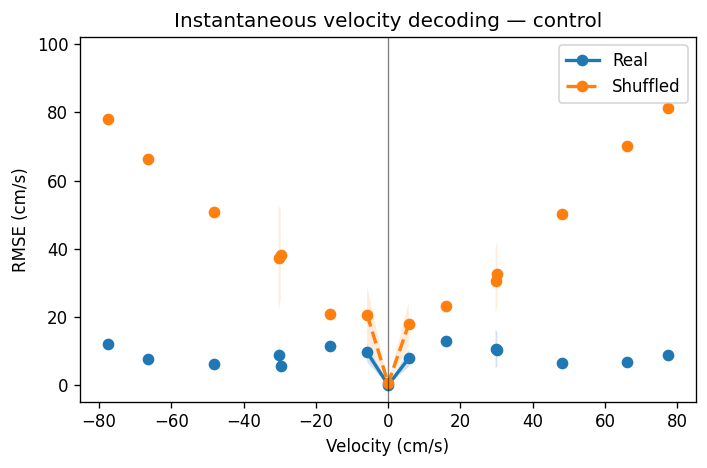

In [24]:
# --- Real ---
vel_r  = Error_v_Vel[:, 0]
rmse_r = Error_v_Vel[:, 1]
sem_r  = Error_v_Vel[:, 2] if Error_v_Vel.shape[1] >= 3 else np.zeros_like(rmse_r)

# --- Shuffled (optional) ---
has_shuf = 'Error_v_Vel_shuf' in globals() and (Error_v_Vel_shuf is not None)
if has_shuf:
    vel_s  = Error_v_Vel_shuf[:, 0]
    rmse_s = Error_v_Vel_shuf[:, 1]
    sem_s  = Error_v_Vel_shuf[:, 2] if Error_v_Vel_shuf.shape[1] >= 3 else np.zeros_like(rmse_s)

plt.figure(figsize=(6,4))

# Real + band
plt.plot(vel_r, rmse_r, '-o', lw=2, label='Real')
plt.fill_between(vel_r, rmse_r - sem_r, rmse_r + sem_r, alpha=0.2)

# Shuffled + band (if available)
if has_shuf:
    plt.plot(vel_s, rmse_s, '--o', lw=2, label='Shuffled')
    plt.fill_between(vel_s, rmse_s - sem_s, rmse_s + sem_s, alpha=0.15)

plt.axvline(0, color='k', lw=0.8, alpha=0.5)
plt.xlabel("Velocity (cm/s)")
plt.ylabel("RMSE (cm/s)")
plt.title(f"Instantaneous velocity decoding — {cond}")
plt.legend()
plt.tight_layout()
plt.show()
